In [2]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(DESeq2)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

### DESeq2 test results

#### less filtering in the DESeq prep

In [10]:
res<- readRDS("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/res_dds.rds")

In [11]:
head(res)

log2 fold change (MLE): Cluster 2 vs 1 
Wald test p-value: Cluster 2 vs 1 
DataFrame with 6 rows and 6 columns
       baseMean log2FoldChange     lfcSE      stat      pvalue        padj
      <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
ASV1  1074.5754       -7.49538   1.17695  -6.36846 1.90942e-10 4.99176e-09
ASV3  1693.0538       -8.66192   1.24982  -6.93055 4.19193e-12 1.13534e-10
ASV5   296.9874       -9.07307   1.56630  -5.79268 6.92740e-09 1.66923e-07
ASV8   131.8377        6.41529   1.57462   4.07418 4.61769e-05 7.73920e-04
ASV9  3919.8008      -11.23067   1.46175  -7.68302 1.55380e-14 4.63470e-13
ASV10   49.7813       -3.89275   1.85343  -2.10030 3.57028e-02 2.02688e-01

In [12]:
res_df <- as.data.frame(res)
res_df$EnrichedIn <- ifelse(res_df$log2FoldChange > 0, "Cluster2", "Cluster1")
class(res_df)

[1] "data.frame"

In [13]:
nrow(res_df)
length(res_df$EnrichedIn)
table(res_df$EnrichedIn)

[1] 6780

[1] 6780


Cluster1 Cluster2 
    4553     2227 

#### ^ making a new df from res with a new column IDing cluster 1 and cluster 2, based on logFC
- fold change is the ratio between the two groups
- FC= (Expression of X in grp2)/(expression of X in grp 1)
- FC=2 logFC=1
- FC=4 logFC=2
- FC=.5 logFC=-1

### DESeq2 volcano
- most statistically significant asvs will be towards the top bc they have the lowest p-values
- EnhancedVolcano will only attempt to label genes that pass the thresholds that you set for statistical significance, i.e., ‘pCutoff’ and ‘FCcutoff’

In [14]:
library(EnhancedVolcano)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


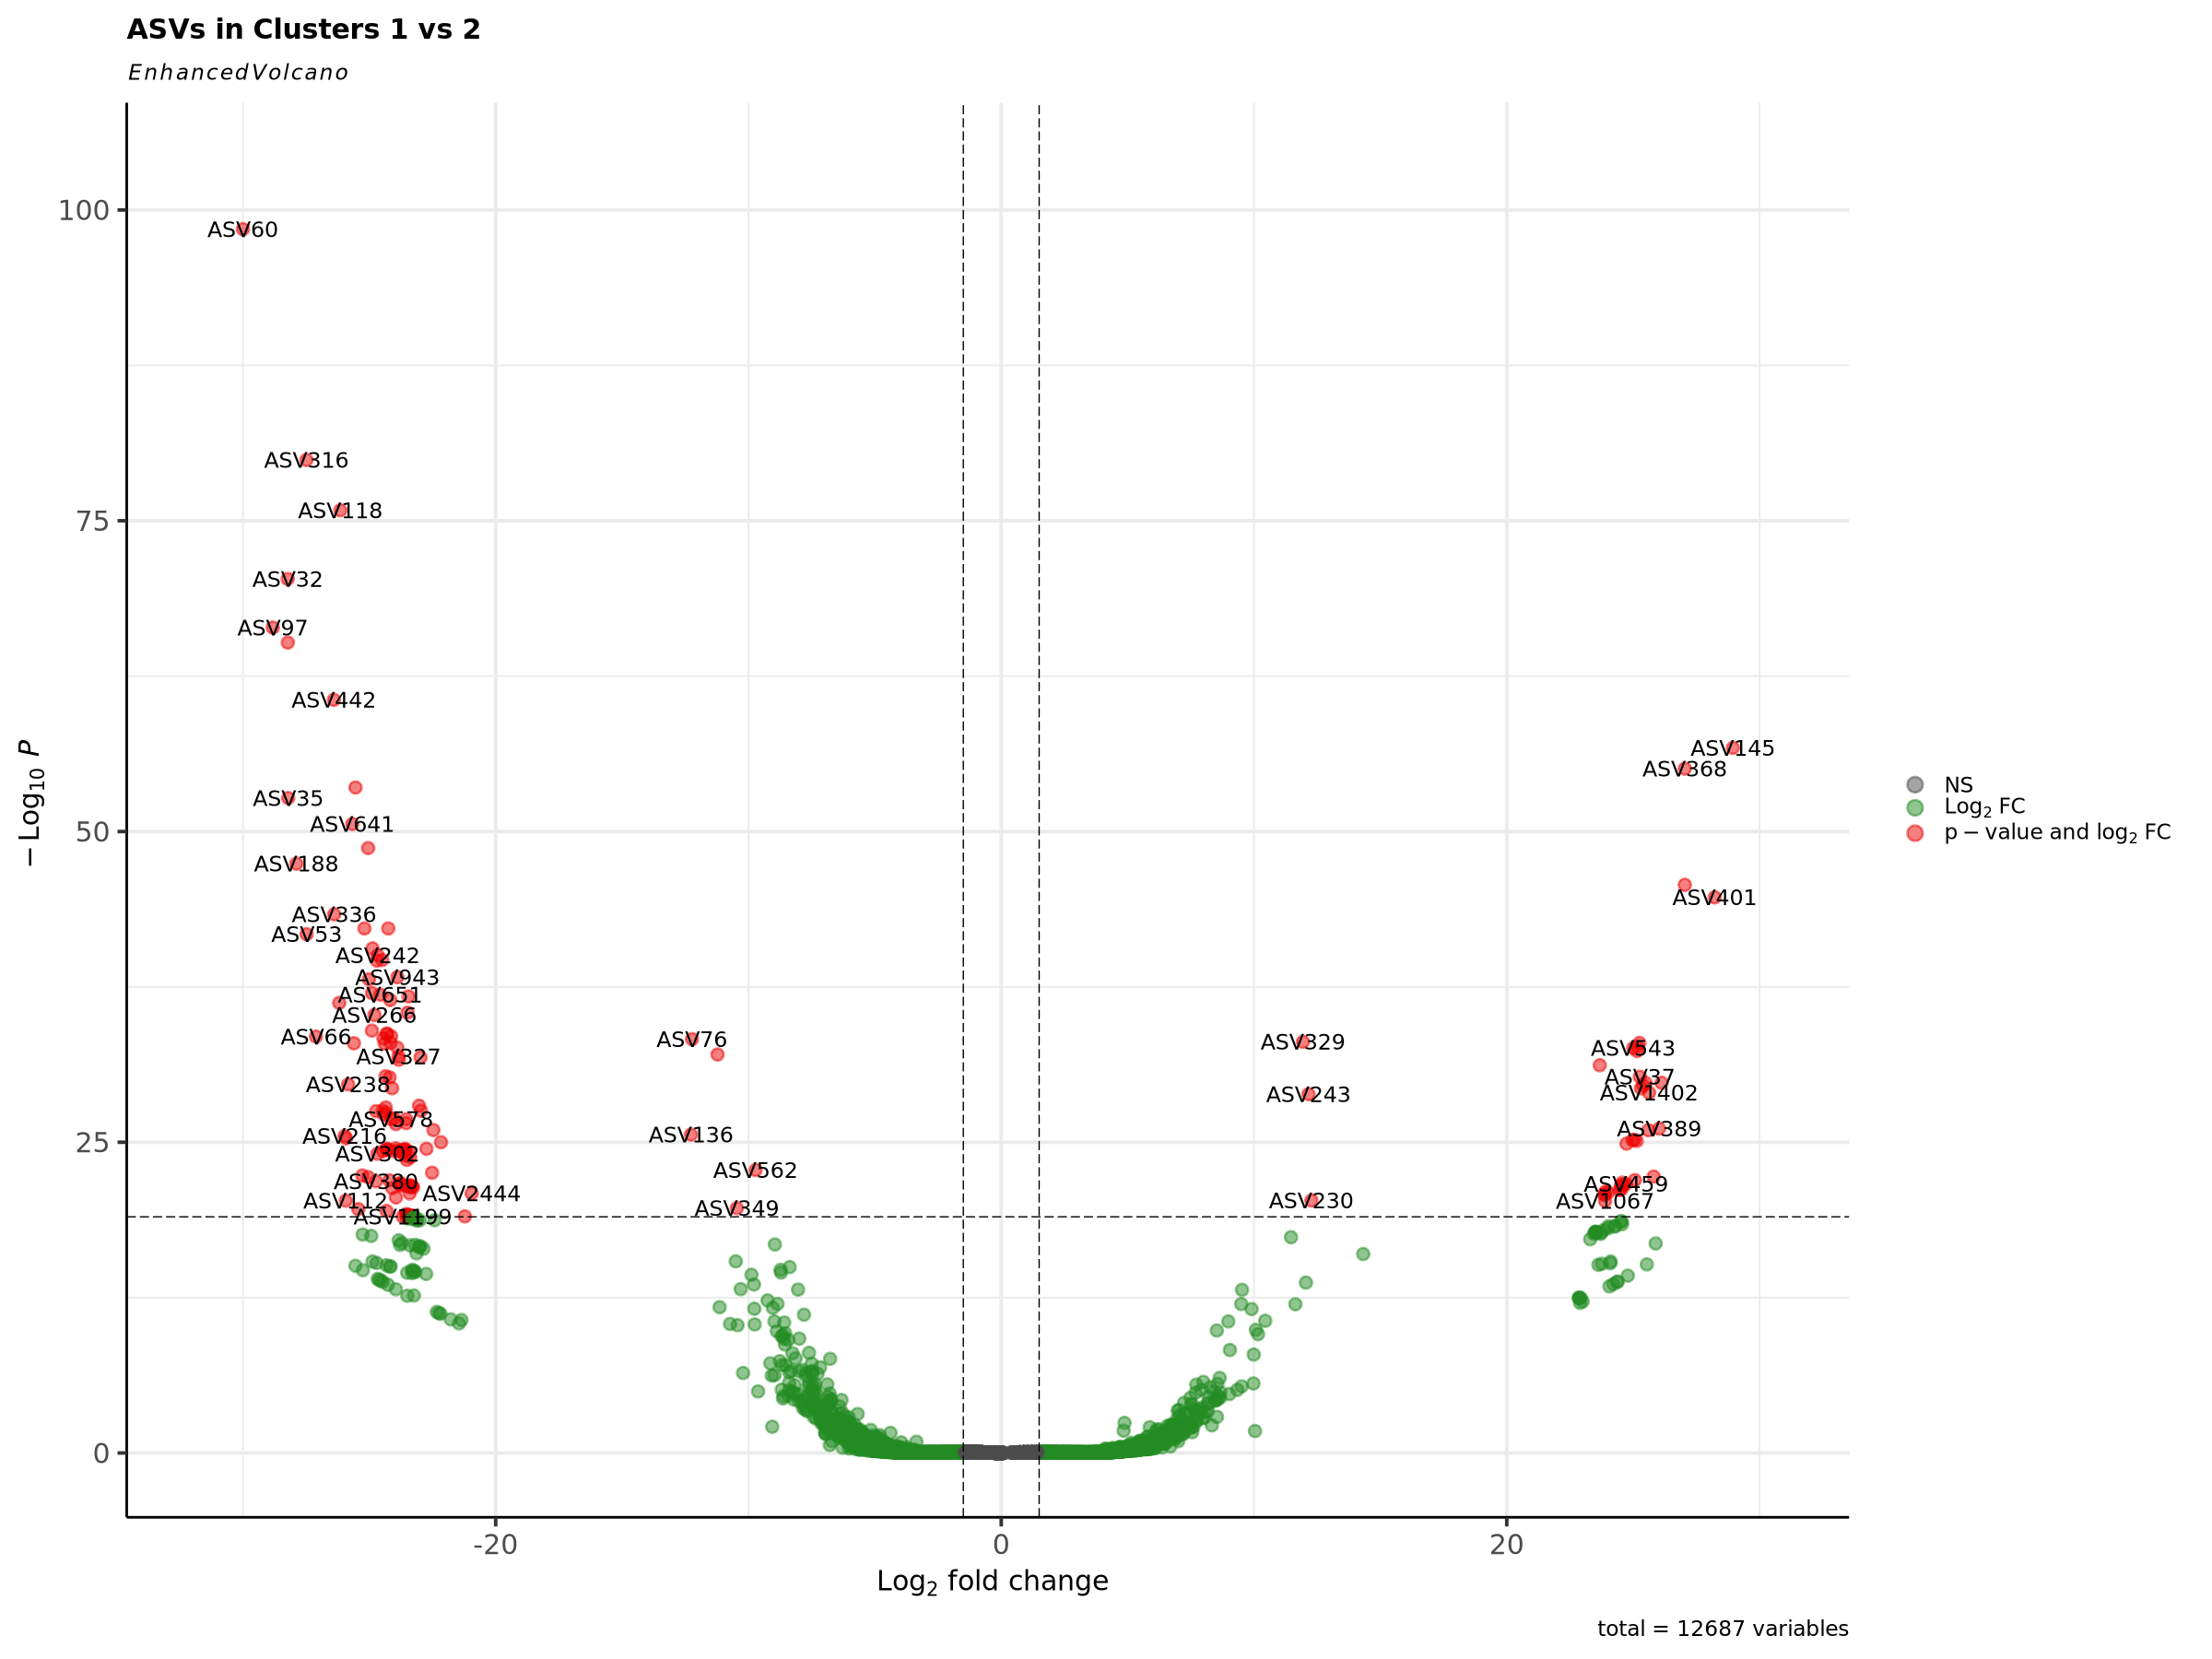

In [8]:
 #first attempt without ASV short names is unreadable
#with ASV short names
#res and sig_cluster look the same
EnhancedVolcano(res_df,
    lab = rownames(res_df),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'ASVs in Clusters 1 vs 2',
    pCutoff =  10e-20, #p value=0.01
    FCcutoff = 1.5,
    pointSize = 3.0,
    legendPosition = 'right',
    legendLabSize = 14,
    legendIconSize = 4.0,)

### interperting volcano plot
- positve LogFC indicates more expression of ASVs in cluster 2
- the higher the -logP the more signifcant

### custom volcano plot: normal deseq results

In [8]:
str(res_df$EnrichedIn)      # Should be a character or factor vector, length 6787
unique(res_df$EnrichedIn)   # Should show only "Cluster 1" and "Cluster 2"
any(is.na(res_df$EnrichedIn))  # Should be FALSE

 chr [1:6780] "Cluster1" "Cluster1" "Cluster1" "Cluster2" "Cluster1" ...


[1] "Cluster1" "Cluster2"

[1] FALSE

In [9]:
 # create custom key-value pairs for different cell-types
  # this can be achieved with nested ifelse statements
keyvals.shape <- ifelse(
  res_df$EnrichedIn == "Cluster1", 17,
  ifelse(res_df$EnrichedIn == "Cluster2", 64, 3)
)

keyvals.shape[is.na(keyvals.shape)] <- 3

names(keyvals.shape)[keyvals.shape == 17] <- "Cluster1"
names(keyvals.shape)[keyvals.shape == 64] <- "Cluster2"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


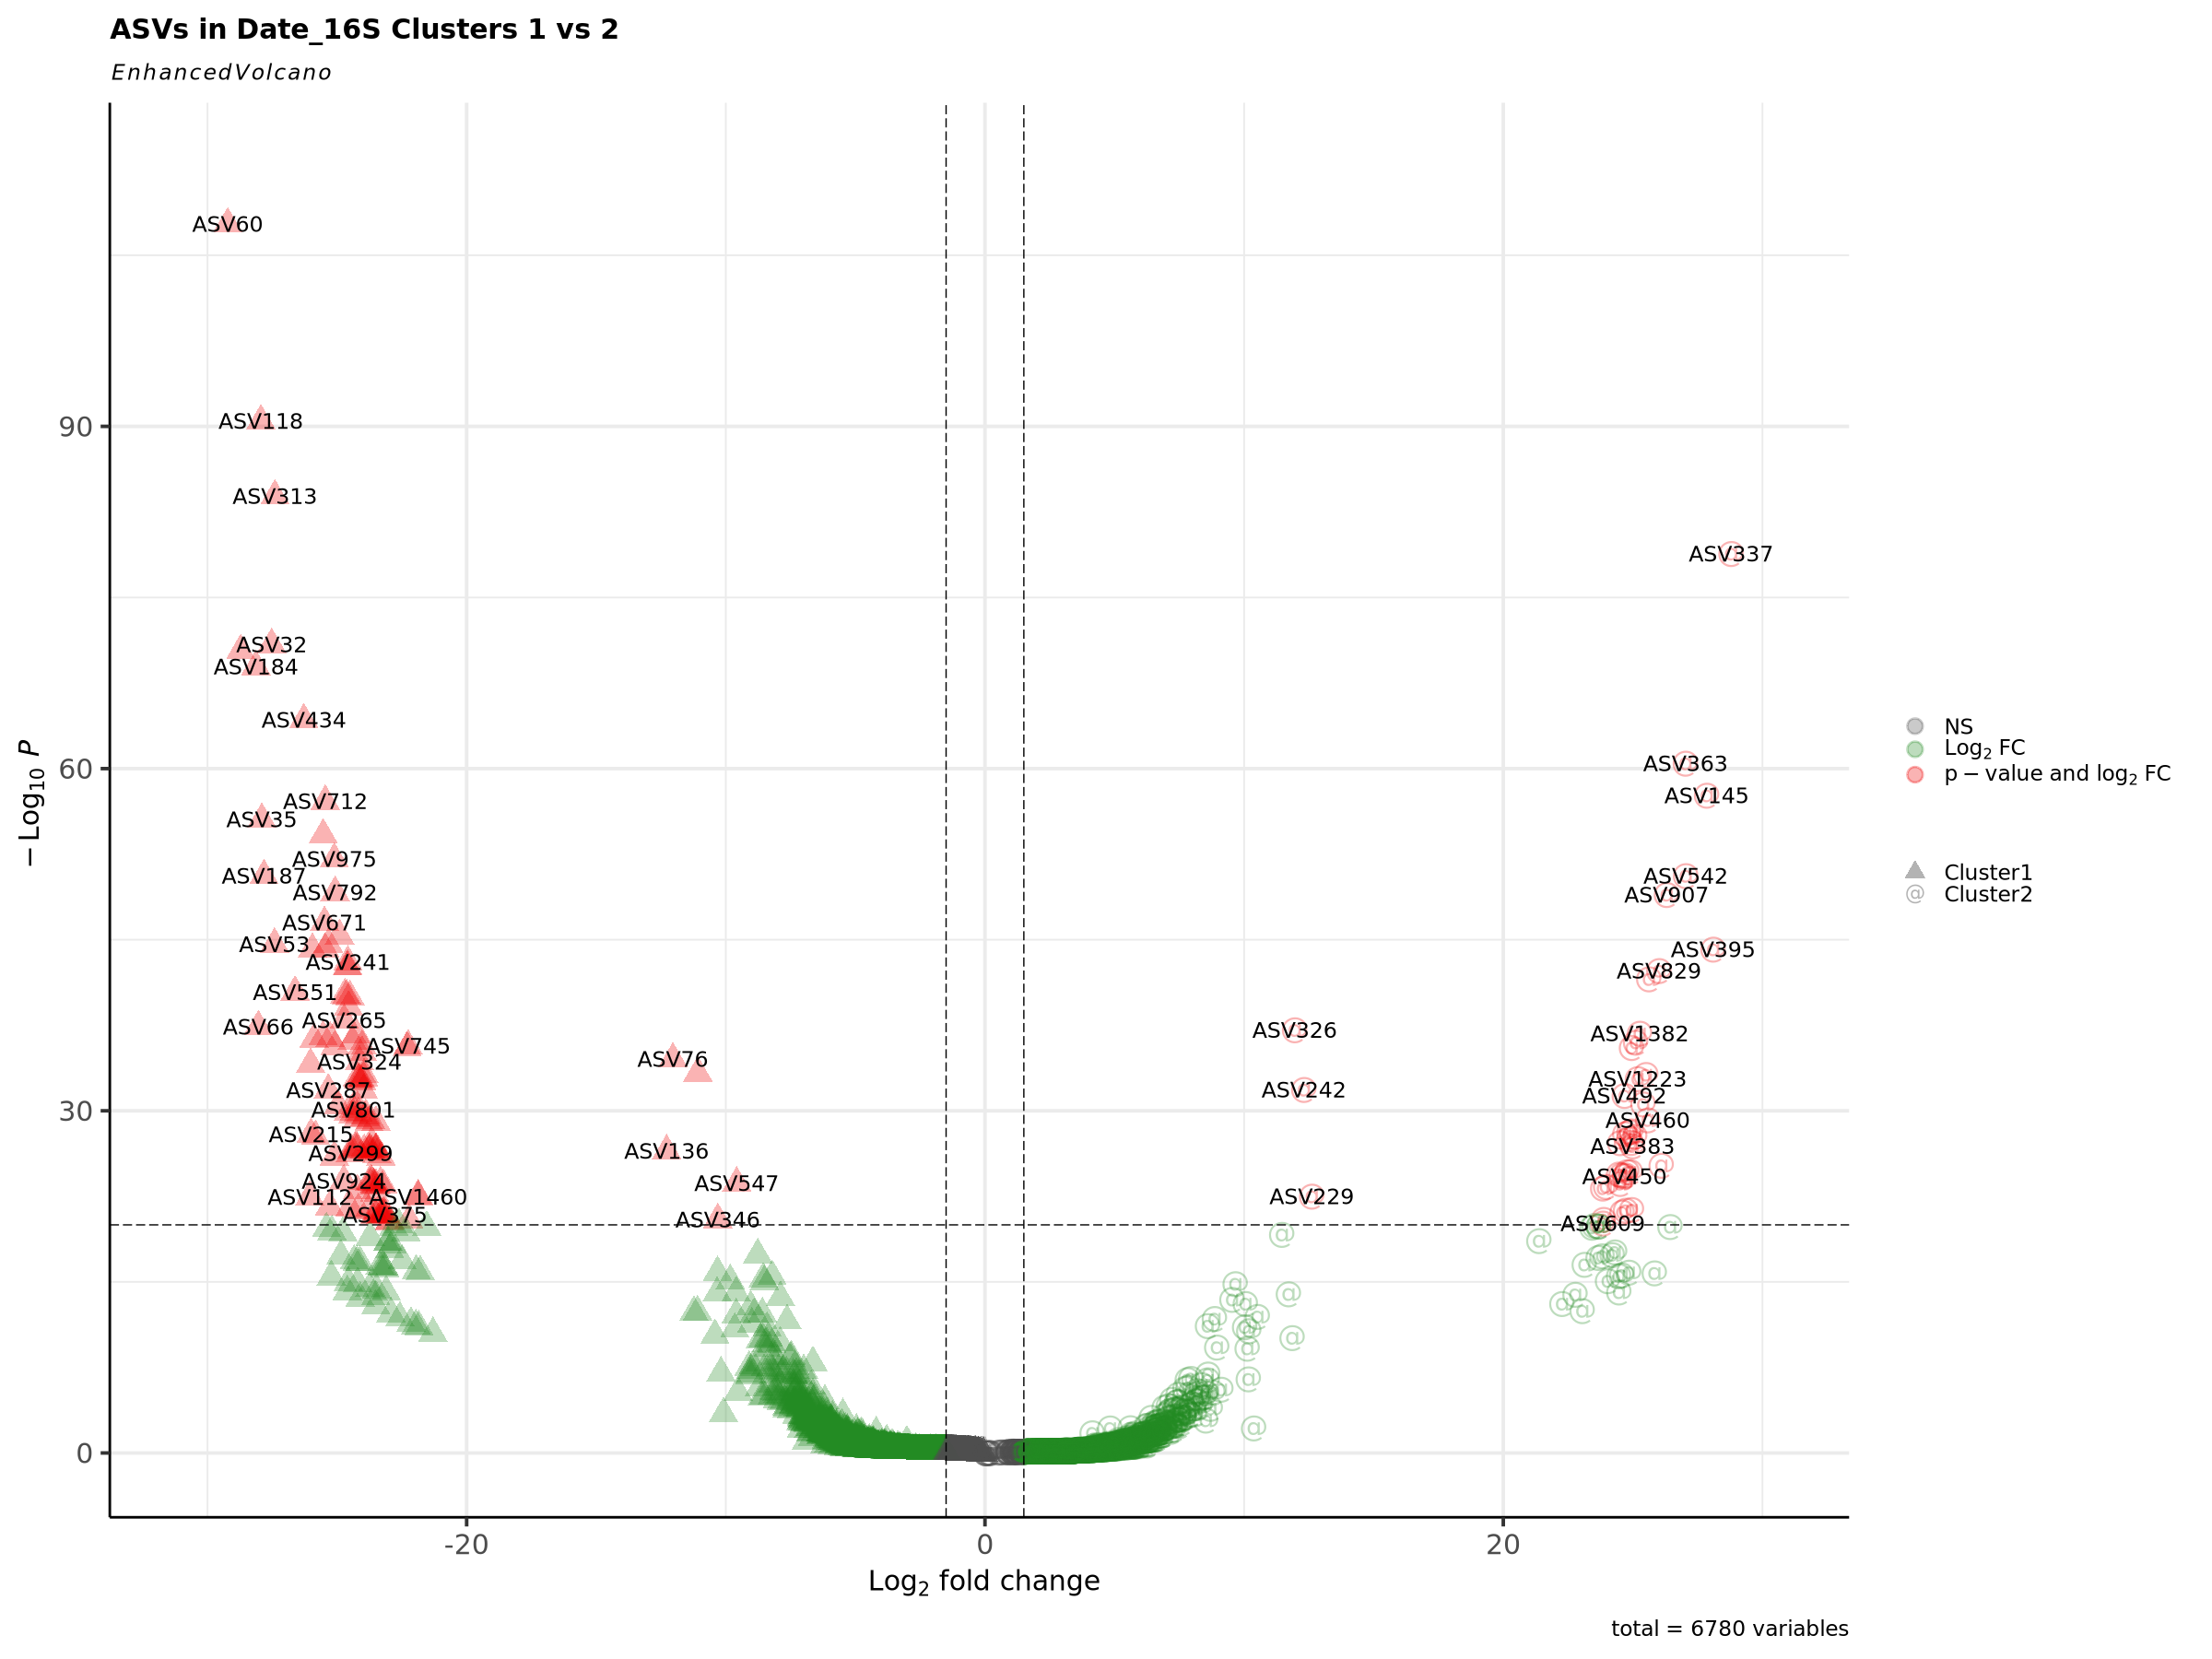

In [10]:
# Step 4: Volcano plot
clusters <- EnhancedVolcano(res_df,
    lab = rownames(res_df),
    x = 'log2FoldChange',
    y = 'padj',
    title = 'ASVs in Date_16S Clusters 1 vs 2',
    pCutoff = 1e-20,
    FCcutoff = 1.5,
    pointSize = 6.0,
    colAlpha = 0.3,
    legendPosition = 'right',
    legendLabSize = 14,
    legendIconSize = 4.0,
shapeCustom = keyvals.shape,
    colCustom = NULL)
clusters

### using significant ASV from volcano plots to find similar taxonomy

In [15]:
asv_map<- readRDS("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/asv_map.rds")

In [16]:
# Set rownames
rownames(asv_map) <- asv_map$ASV 
asv_map$ASV <- NULL  

In [17]:
head(asv_map)
colnames(asv_map)

,Sequence
,<chr>
ASV1,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG
ASV2,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA
ASV3,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG
ASV4,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA
ASV5,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG
ASV6,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG


[1] "Sequence"

In [18]:
sig_asvs<- res_df[res_df$pvalue < 1e-20, ]
head(sig_asvs)
NROW(sig_asvs)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,EnrichedIn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ASV32,364.1570,-27.52451,1.5048711,-18.29028,9.890801e-75,1.339412e-71,Cluster1
ASV35,296.7819,-27.90433,1.7224825,-16.20007,5.037324e-59,2.842310e-56,Cluster1
ASV53,191.9964,-27.41362,1.8868859,-14.52850,7.995561e-48,2.460816e-45,Cluster1
ASV60,736.8522,-29.21822,1.2974839,-22.51914,2.695548e-112,1.825155e-108,Cluster1
ASV66,295.8406,-28.03719,2.1081841,-13.29921,2.339198e-40,4.280732e-38,Cluster1
ASV76,547.1768,-12.04257,0.9424843,-12.77748,2.190564e-37,2.852368e-35,Cluster1


[1] 174

In [19]:
#inner join
sig_asv_map <- merge(sig_asvs, asv_map, by = "row.names")
#undo the extra column i made 
rownames(sig_asv_map) <- sig_asv_map$Row.names
sig_asv_map$Row.names <- NULL
head(sig_asv_map)
NROW(sig_asv_map)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,EnrichedIn,Sequence
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ASV1003,7.626857,-22.96175,2.339638,-9.814233,9.777896e-23,4.271363e-21,Cluster1,TACGGAGGGTGCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGCAGGCGGTCAATTAAGTCAGAGGTGAAATCCCATAGCTTAACTATGGAACTGCCTTTGATACTGGTTGACTTGAGTTATACGGAAGTAGATAGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAATACCGATTGCGAAGGCAGTCTACTACGTATATACTGACGCTCATGGACGAAAGCGTGGGGAGCGAACAGG
ASV1005,31.580708,-24.63301,1.788980,-13.769303,3.899595e-43,8.001261e-41,Cluster1,GACGGAGGATGCAAGTGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAATAAGTCAACTGTTAAATCTTAAAGCTTAACTTTGAAATCGCAGTCGAAACTATTAGACTAGAGTATAGTAGGGGTAAAGGGAATTTCCAGTGGAGCGGTGAAATGCGTAGAGATTGGAAAGAACACCGATGGCGAAGGCACTTTACTGGGCTATTACTAACACTCAGAGACGAAAGCTAGGGTAGCAAATGGG
ASV1027,31.017914,-24.95190,2.080770,-11.991670,3.929043e-33,3.855587e-31,Cluster1,AGATGTGTATAAGAGACAGAGTGTCAGCAGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATGGTGCAATATTAAAAGAAAAAAAAGAATTTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCGAACAGGATTAGATACCCTCGTAGTCCACTGTCTCTTATACACATCTCCGAGCCCACGAGACGACGA
ASV1039,28.657371,-24.55704,1.805864,-13.598495,4.087567e-42,7.907690e-40,Cluster1,AGATGTGTATAAGAGACAGAGTGTCAGCAGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATGGTGCAATATTAAAAGAAAAAAAAGAATTTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCGAACAGGATTAGAAACCCTCGTAGTCCACTGTCTCTTATACACATCTCCGAGCCCACGAGACGACGA
ASV1046,10.837314,-23.52005,2.369441,-9.926412,3.195472e-23,1.432884e-21,Cluster1,TACGTAGGGGGCAAGCGTTGTCCGGAATCACTGGGCGTAAAGCGCGCGCAGGCGGTGGAGTAAGTCAGACGTGAAAGGGTTCGGCTCAACCGAGCCATTGCGTTTGATACTGCTTCACTTGAGTCTAGAAGAGGAAAGTGGAATGTATGGTGTAGCGGTGGAATGCTTAGATATCATATAGAACACCCGTGGCGAAGGCGGCTTTCTGGTCTAAGACTGACGCTCATGCGCGAAAGTTTGGGGAGCAACCGGG
ASV1048,27.307599,-22.29747,1.721153,-12.954963,2.202411e-38,2.982504e-36,Cluster1,AGATGTGTATAAGAGACAGAGTGTCAGCAGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATGGTGCAATATTAAAAGAAAAAAAAGAATTTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCGAACAGGATTAGAAACCCCAGTAGTCCACTGTCTCTTATACACATCTCCGAGCCCACGAGACGACGA


[1] 174

### comparing sig ASV to taxa in ps_clean

In [20]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps_final.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [21]:
#getting rid of samples in phyloseq with very low-abundance or rarely occurring taxa
    # Remove taxa not seen in at least 3 samples AND total abundance less than 6
    ps <- phyloseq::filter_taxa(ps, function(x) sum(x > 0) > 2 & sum(x) > 5, TRUE)

In [22]:
#isolate just bacteria
ps_bac=subset_taxa(ps, Kingdom=="Bacteria")
#remove chloroplast order
ps_nochlo=subset_taxa(ps_bac, Order!="Chloroplast")
ps_clean=subset_taxa(ps_nochlo, Family!="Mitochondria")

In [23]:
ps_clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6780 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 6780 taxa by 6 taxonomic ranks ]

In [24]:
#make taxa table have an ASV column 
tax_table_df <- as.data.frame(tax_table(ps_clean))
head(tax_table_df)

,Kingdom,Phylum,Class,Order,Family,Genus
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Endozoicomonadaceae,Parendozoicomonas
ATACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACGGGA,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Vibrionaceae,Vibrio
TACGAAGGGAGCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGGAGCGAACGGG,Bacteria,Pseudomonadota,Alphaproteobacteria,Rhodospirillales,Terasakiellaceae,Marivibrio


In [25]:
tax_table_df$Sequence <- row.names(tax_table_df)
#merge asv map and taxonomy table
taxa_sig_asvs <- merge(tax_table_df, sig_asv_map, by = "Sequence", all.x = TRUE)

In [26]:
taxa_sig_asvs <- taxa_sig_asvs[match(sig_asv_map$Sequence, taxa_sig_asvs$Sequence), ]
rownames(taxa_sig_asvs) <- rownames(sig_asv_map)
head(taxa_sig_asvs)

,Sequence,Kingdom,Phylum,Class,Order,Family,Genus,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,EnrichedIn
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ASV1003,TACGGAGGGTGCAAGCGTTATCCGGAATCATTGGGTTTAAAGGGTCCGCAGGCGGTCAATTAAGTCAGAGGTGAAATCCCATAGCTTAACTATGGAACTGCCTTTGATACTGGTTGACTTGAGTTATACGGAAGTAGATAGAATGTGTAGTGTAGCGGTGAAATGCATAGATATTACACAGAATACCGATTGCGAAGGCAGTCTACTACGTATATACTGACGCTCATGGACGAAAGCGTGGGGAGCGAACAGG,Bacteria,Bacteroidota,Bacteroidia,Flavobacteriales,Flavobacteriaceae,Aurantivirga,7.626857,-22.96175,2.339638,-9.814233,9.777896e-23,4.271363e-21,Cluster1
ASV1005,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ASV1027,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ASV1039,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ASV1046,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ASV1048,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### these are my significant asvs from the volcano plots
- mapped out the taxa
- and the data from deseq2

In [34]:
#wider plots
#making plots small 
options(repr.plot.width = 25, repr.plot.height = 8)
#color assignment
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(13)

Warning message:
“Removed 115 rows containing missing values or values outside the scale range
(`geom_point()`).”


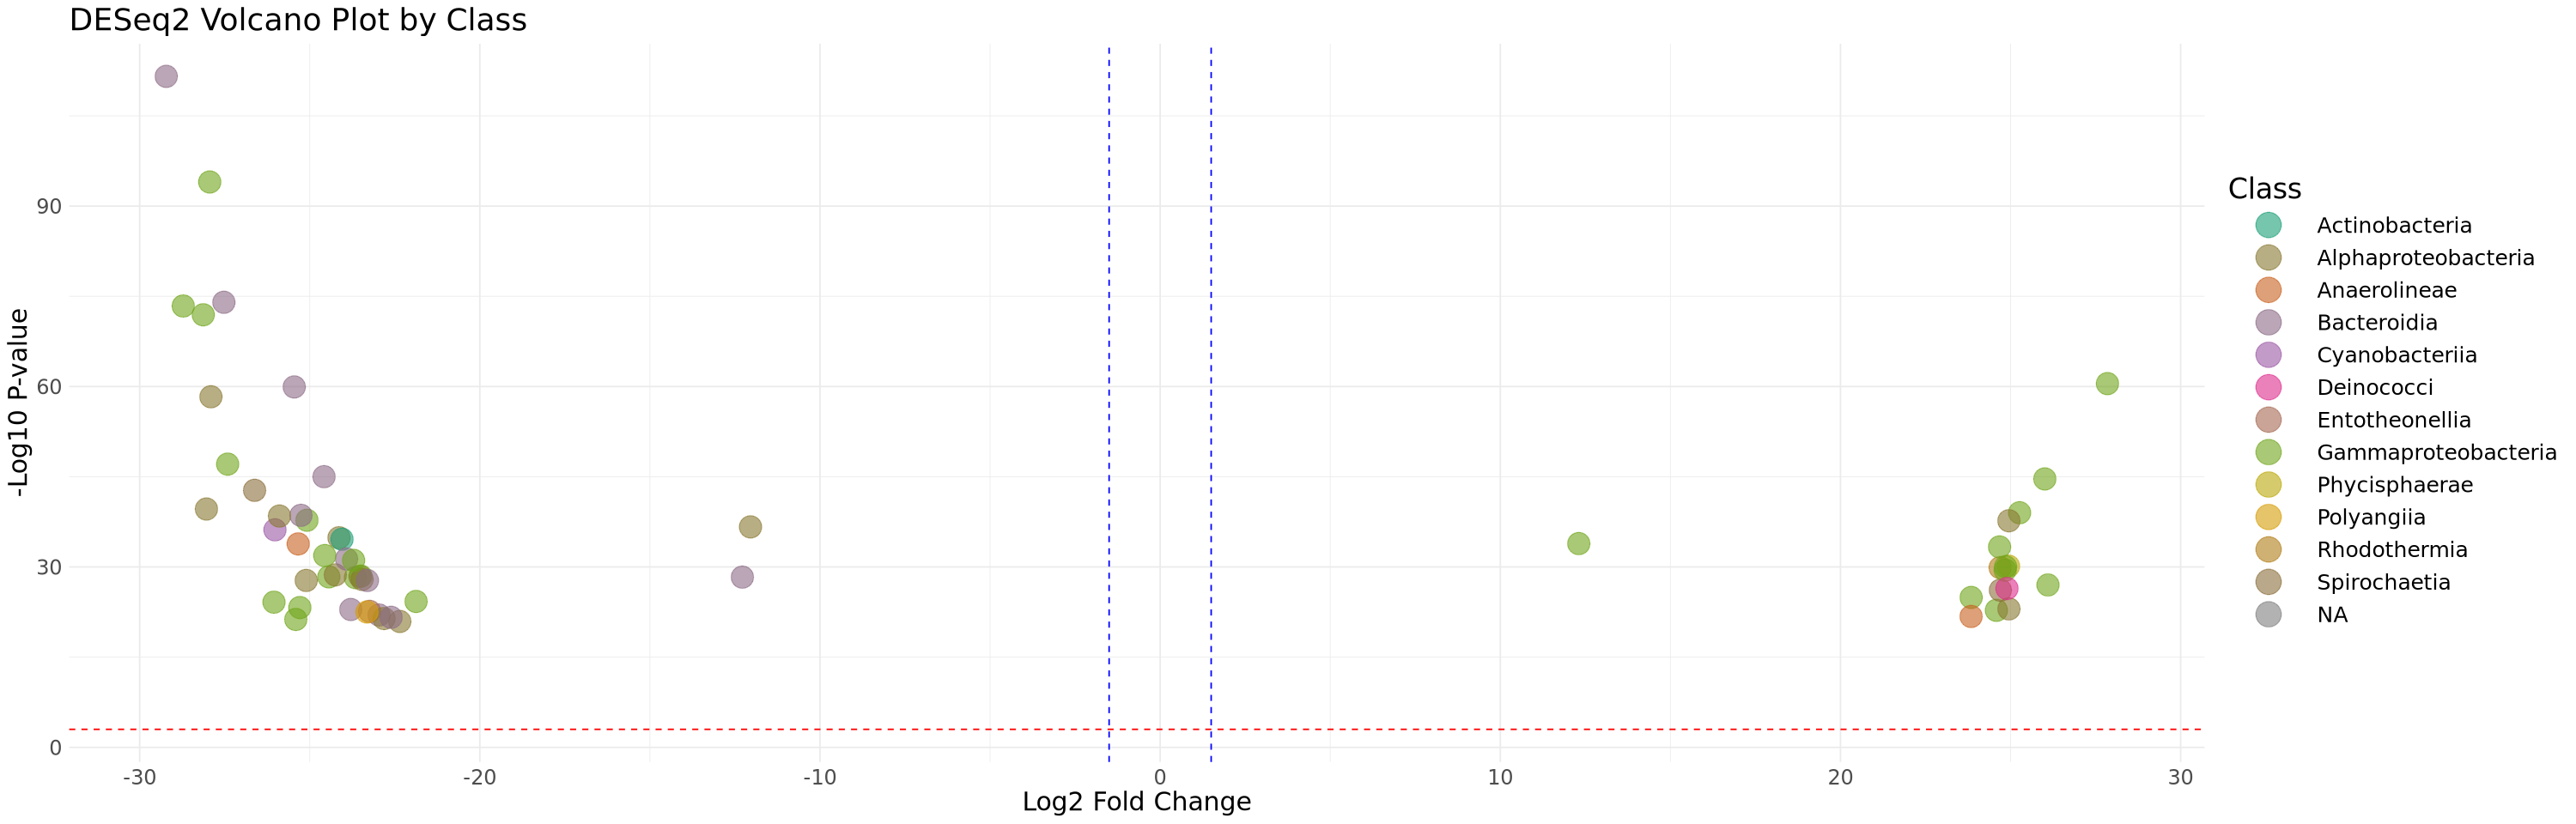

In [35]:
volcano_taxa <- ggplot(taxa_sig_asvs, aes(x = log2FoldChange, y = -log10(pvalue))) +
  geom_point(aes(color = Class), alpha = 0.6, size = 7) +
  labs(title = "DESeq2 Volcano Plot by Class",
       x = "Log2 Fold Change",
       y = "-Log10 P-value",
       color = "Class") +
  #Use the same color palette for both
scale_color_manual(values = mycolors, drop = TRUE)+
  theme_minimal() +
theme(
  legend.position = "right", 
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  text = element_text(size = 18),
  legend.key.width = unit(2, "cm"),     # make the legend keys wider
  legend.key.height = unit(0.8, "cm")   # make them taller
) +
guides(color = guide_legend(override.aes = list(size = 8)))+
  # Add lines for significance and fold change thresholds
  geom_hline(yintercept = -log10(0.001), linetype = "dashed", color = "red") +
  geom_vline(xintercept = c(-1.5, 1.5), linetype = "dashed", color = "blue")
volcano_taxa

In [27]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plot_volcano_taxa.png", plot = volcano_taxa, width = 8, height = 6, units = "in", dpi = 300)

### Heatmap

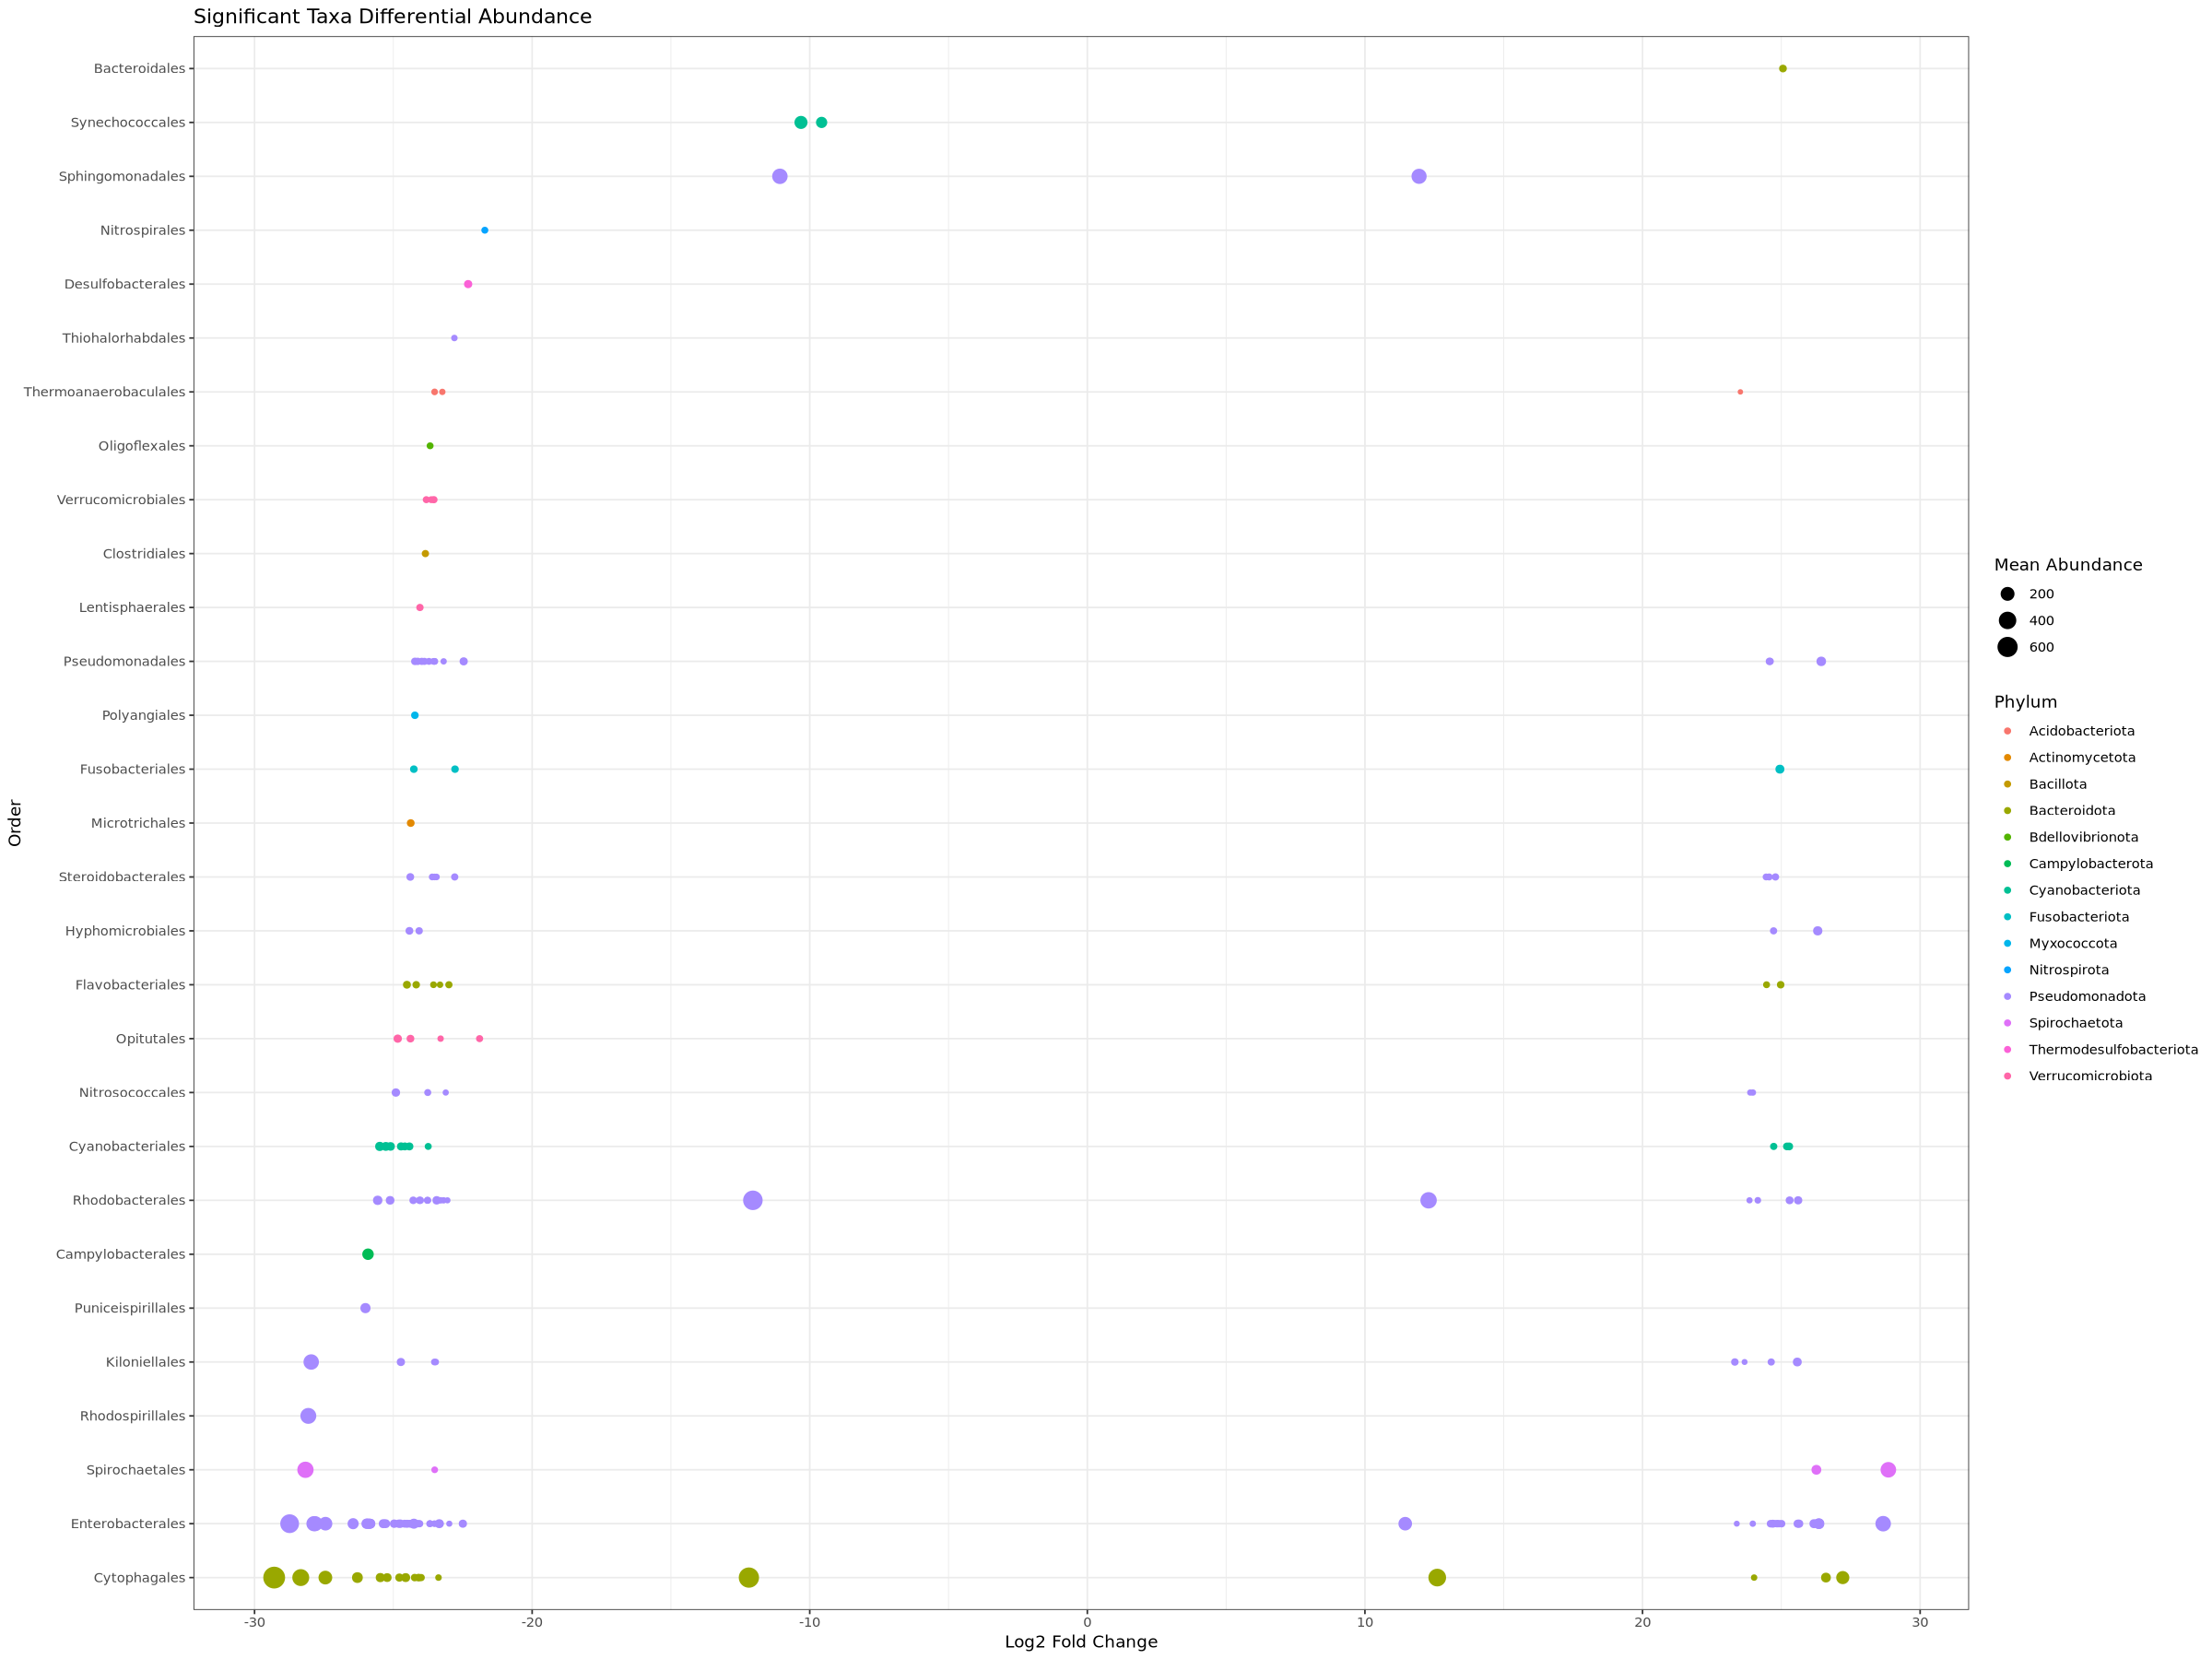

In [72]:

# Filter for significant results (e.g., adjusted p-value < 0.05 and |LFC| > 1)
sig_taxa <- subset(taxa_sig_asvs, padj < 0.001 & abs(log2FoldChange) > 1.5)

# Order taxa for plotting
sig_taxa$Order <- factor(sig_taxa$Order, levels = unique(sig_taxa$Order[order(sig_taxa$log2FoldChange)]))

ggplot(sig_taxa, aes(x = log2FoldChange, y = Order)) +
  geom_point(aes(size = baseMean, color = Phylum)) +
  labs(title = "Significant Taxa Differential Abundance",
       x = "Log2 Fold Change",
       y = "Order",
       size = "Mean Abundance",
       color = "Phylum") +
  theme_bw()

In [ ]:
library(pheatmap)

### what does this plot do??

In [ ]:
scale_fill_discrete <- function(palname = "Set3", ...) {
    scale_fill_brewer(palette = palname, ...)
}
# Phylum order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Phylum, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Phylum = factor(as.character(sig_cluster$Phylum), levels=names(x))
# Genus order
x = tapply(sig_cluster$log2FoldChange, sig_cluster$Family, function(x) max(x))
x = sort(x, TRUE)
sig_cluster$Family = factor(as.character(sig_cluster$Family), levels=names(x))
ggplot(sig_cluster, aes(x=Family, y=log2FoldChange, color=Phylum)) + geom_point(size=6) + 
  theme(axis.text.x = element_text(angle = -90, hjust = 0, vjust=0.5))